In [1]:
# Imports
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn, optim

from sklearn import decomposition
from sklearn.datasets import fetch_openml

In [2]:
def visualize_image(X, n_row=5, n_col=5, rand=True):
    image_size = [28, 28]
    
    for idx in range(n_row * n_col):
        if rand:
            image_id = np.random.randint(0, X.shape[1])
        else:
            image_id = idx
        image = X[:, image_id].reshape(image_size)

        plt.subplot(n_row, n_col, idx + 1)
        plt.imshow(image, cmap='gray')
        plt.axis('off')

In [92]:
import functools as ft
def analysis_weight(network):
    para  = list(network.parameters())
    net_W = ft.reduce(lambda a, b: b @ a, \
                      [w.detach().numpy() for w in para])
    return np.diag(components @ net_W @ components.T)

In [3]:
# MNIST dataset
X, y = fetch_openml('mnist_784', version=1, return_X_y=True)
X = X.T / 255
X.shape

(784, 70000)

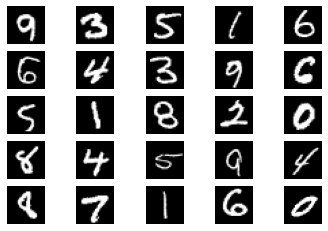

In [4]:
# Plot image
n_plot = 10
image_size = [28, 28]

visualize_image(X)

## PCA Analysis

In [5]:
# Zero center
row_mean = X.mean(axis=1)
X_zero = X - row_mean.reshape([-1, 1])

In [6]:
# PCA
pca = decomposition.PCA()
pca.fit(X_zero.T)
components = pca.components_
components.shape

(784, 784)

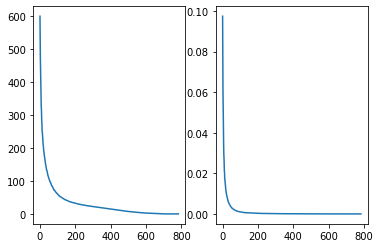

In [7]:
# Plot eigenval
plt.subplot(1, 2, 1)
plt.plot(pca.singular_values_)

plt.subplot(1, 2, 2)
plt.plot(pca.explained_variance_ratio_)

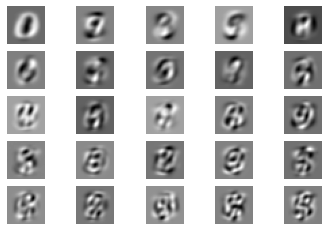

In [8]:
# PCA Basis
visualize_image(components.T, rand=False)

In [9]:
# PCA transformation
n_comp = 20
comp = components[:n_comp, :]
print(comp.shape)

proj = comp @ X_zero
print(proj.shape)

recon = comp.T @ proj
recon_mean = recon + row_mean.reshape([-1, 1])
print(recon.shape)

(20, 784)
(20, 70000)
(784, 70000)


In [10]:
# PCA loss
loss_func = nn.MSELoss()
loss_func(torch.from_numpy(X_zero.T.astype(np.float32)), \
          torch.from_numpy(recon.T.astype(np.float32)))

tensor(0.0239)

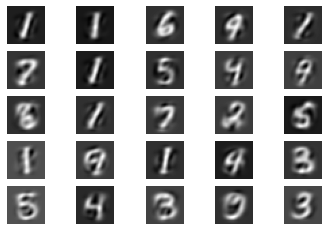

In [11]:
# Show reconstruction
n_row, n_col = (5, 5)
image_size = [28, 28]

visualize_image(recon_mean)

## PCA with linear neural network

In [22]:
n_comp = 20
input_size = 28 * 28

input_X = torch.from_numpy(X_zero.T.astype(np.float32))
print(input_X.shape)

shallow_nn = nn.Sequential(
    nn.Linear(input_size, n_comp, bias=False),    
    nn.Linear(n_comp, input_size, bias=False))

torch.Size([70000, 784])


(784, 70000)


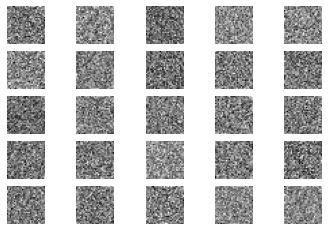

In [23]:
# Before training
with torch.no_grad():
    output = shallow_nn(input_X)
    output = output.detach().numpy().T
    print(output.shape)

    visualize_image(output)

iteration 0 / 600
iteration 50 / 600
iteration 100 / 600
iteration 150 / 600
iteration 200 / 600
iteration 250 / 600
iteration 300 / 600
iteration 350 / 600
iteration 400 / 600
iteration 450 / 600
iteration 500 / 600
iteration 550 / 600


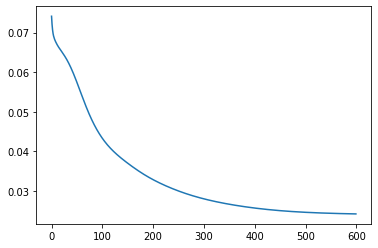

In [24]:
# Gradient descent training
n_iter = 600
optimizer = optim.Adam(shallow_nn.parameters())
# optimizer = optim.SGD(shallow_nn.parameters(), lr=0.05)

loss_func = nn.MSELoss()
loss_val  = np.zeros(n_iter)
for iter in range(n_iter):
    if iter % 50 == 0:
        print('iteration %d / %d' % (iter, n_iter))
        
    optimizer.zero_grad()

    output_X = shallow_nn(input_X)
    loss = loss_func(output_X, input_X)
    loss_val[iter] = loss

    loss.backward()
    optimizer.step()

plt.plot(range(n_iter), loss_val)

tensor(0.0242)
(784, 70000)


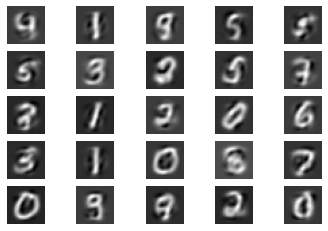

In [25]:
# After training
with torch.no_grad():
    output = shallow_nn(input_X)
    print(loss_func(output_X, input_X))
    
    output = output.detach().numpy().T
    output = output + row_mean.reshape([-1, 1])
    print(output.shape)

    visualize_image(output)

## Deeper Network

In [116]:
n_mid, n_comp = (50, 20)
input_size = 28 * 28

input_X = torch.from_numpy(X_zero.T.astype(np.float32))

deep_nn = nn.Sequential(
    nn.Linear(input_size, n_mid, bias=False),    
    nn.Linear(n_mid, n_comp, bias=False),
    nn.Linear(n_comp, n_mid, bias=False),
    nn.Linear(n_mid, input_size, bias=False))

(784, 70000)


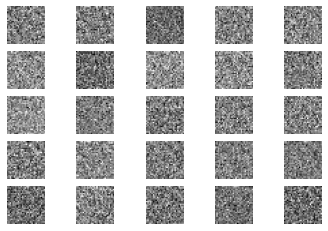

In [117]:
# Before training
with torch.no_grad():
    output = deep_nn(input_X)
    output = output.detach().numpy().T
    print(output.shape)

    visualize_image(output)  

iteration 0 / 600
iteration 50 / 600
iteration 100 / 600
iteration 150 / 600
iteration 200 / 600
iteration 250 / 600
iteration 300 / 600
iteration 350 / 600
iteration 400 / 600
iteration 450 / 600
iteration 500 / 600
iteration 550 / 600


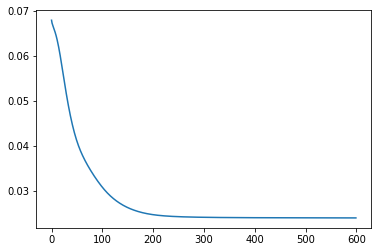

In [118]:
# Gradient descent training
n_iter = 600
optimizer = optim.Adam(deep_nn.parameters())

loss_func = nn.MSELoss()
loss_val  = np.zeros(n_iter)
for iter in range(n_iter):
    if iter % 50 == 0:
        print('iteration %d / %d' % (iter, n_iter))
        
    optimizer.zero_grad()

    output_X = deep_nn(input_X)
    loss = loss_func(output_X, input_X)
    loss_val[iter] = loss

    loss.backward()
    optimizer.step()

plt.plot(range(n_iter), loss_val)

tensor(0.0240)
(784, 70000)


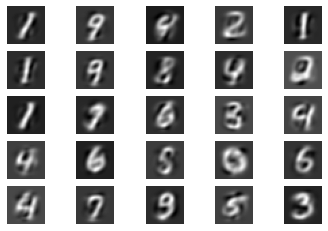

In [119]:
# After training
with torch.no_grad():
    output = deep_nn(input_X)
    print(loss_func(output_X, input_X))
    
    output = output.detach().numpy().T
    output = output + row_mean.reshape([-1, 1])
    print(output.shape)

    visualize_image(output)

## Analysis of the weight matrix (it's alignment with PCA basis)

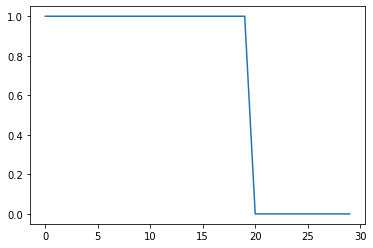

In [160]:
pca_W = comp.T @ comp
n_item = 30

# decomposition with PCA basis
diag = np.diag(components @ pca_W @ components.T)
plt.plot(diag[0:n_item])

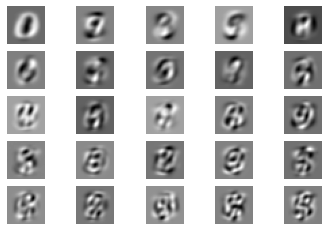

In [78]:
visualize_image(components.T, n_row=5, n_col=5, rand=False)

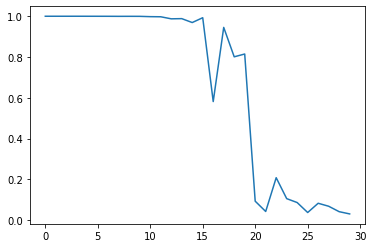

In [172]:
# decomposition with PCA basis
diag = analysis_weight(shallow_nn)
plt.plot(diag[0:n_item])

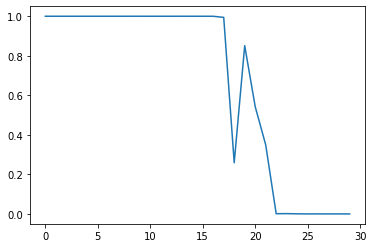

In [143]:
# decomposition with PCA basis
diag = analysis_weight(deep_nn)
plt.plot(diag[0:n_item])

## Now let's look at the temporal dynamics of learning

In [177]:
n_mid, n_comp = (50, 20)
input_size = 28 * 28

input_X = torch.from_numpy(X_zero.T.astype(np.float32))

deep_nn = nn.Sequential(
    nn.Linear(input_size, n_mid, bias=False),    
    nn.Linear(n_mid, n_comp, bias=False),
    nn.Linear(n_comp, n_mid, bias=False),
    nn.Linear(n_mid, input_size, bias=False))

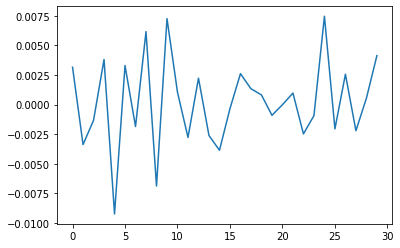

In [178]:
# Before training
diag = analysis_weight(deep_nn)
plt.plot(diag[0:n_item])

(784, 70000)


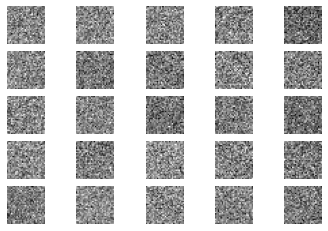

In [179]:
# Before training
with torch.no_grad():
    output = deep_nn(input_X)
    output = output.detach().numpy().T
    print(output.shape)

    visualize_image(output)  

iteration 0 / 600
iteration 50 / 600
iteration 100 / 600
iteration 150 / 600
iteration 200 / 600
iteration 250 / 600
iteration 300 / 600
iteration 350 / 600
iteration 400 / 600
iteration 450 / 600
iteration 500 / 600
iteration 550 / 600


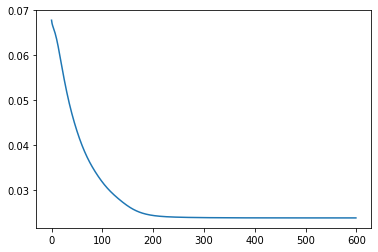

In [184]:
# Gradient descent training
n_iter = 600
optimizer = optim.Adam(deep_nn.parameters())

loss_func = nn.MSELoss()
loss_val  = np.zeros(n_iter)
diag_val  = np.zeros([n_iter, n_item])
for iter in range(n_iter):
    if iter % 50 == 0:
        print('iteration %d / %d' % (iter, n_iter))

    # diagonalization of network transformation with PCA basis
    diag = analysis_weight(deep_nn)
    diag_val[iter, :] = diag[0:n_item]
    
    optimizer.zero_grad()

    output_X = deep_nn(input_X)
    loss = loss_func(output_X, input_X)
    loss_val[iter] = loss

    loss.backward()
    optimizer.step()    

plt.plot(range(n_iter), loss_val)

tensor(0.0239)
(784, 70000)


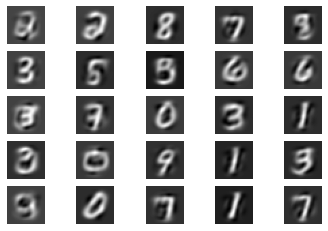

In [185]:
# make sure learning looks good
with torch.no_grad():
    output = deep_nn(input_X)
    print(loss_func(output_X, input_X))
    
    output = output.detach().numpy().T
    output = output + row_mean.reshape([-1, 1])
    print(output.shape)

    visualize_image(output)

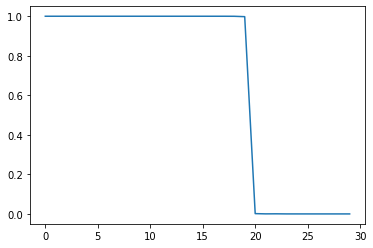

In [186]:
# make sure decomposition with PCA basis looks good
diag = analysis_weight(deep_nn)
plt.plot(diag[0:n_item])

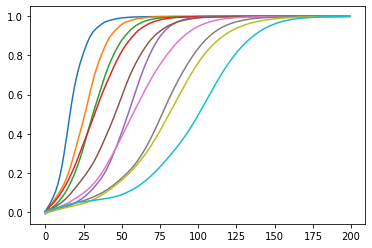

In [192]:
# plot temporal trajectory of diag value
plot_n = 10
t_step = 200
for idx in range(plot_n):
    plt.plot(range(t_step), diag_val[:t_step, idx])

## put all these into a function...

In [89]:
def visualize_temporal(network, n_iter=300, n_item=30, n_plot=15, t_step=300, sgd=False):
    fig = plt.figure(figsize=(6, 16), dpi=100)
                   
    # Before training
    plt.subplot(4, 1, 1)
    diag = analysis_weight(network)
    plt.plot(diag[0:n_item])
    plt.title('before learning')
    
    # Gradient descent training
    if sgd:
        optimizer = optim.SGD(network.parameters(), lr=0.5, momentum=0.5)
    else:
        optimizer = optim.Adam(network.parameters())        

    loss_func = nn.MSELoss()
    loss_val  = np.zeros(n_iter)
    diag_val  = np.zeros([n_iter, n_item])
    for iter in range(n_iter):
        if iter % 50 == 0:
            print('iteration %d / %d' % (iter, n_iter))

        # diagonalization of network transformation with PCA basis
        diag = analysis_weight(network)
        diag_val[iter, :] = diag[0:n_item]
    
        optimizer.zero_grad()

        output_X = network(input_X)
        loss = loss_func(output_X, input_X)
        loss_val[iter] = loss

        loss.backward()
        optimizer.step()    
    
    plt.subplot(4, 1, 2)
    plt.plot(range(n_iter), loss_val)
    plt.title('loss wrt T')
    
    # After training
    plt.subplot(4, 1, 3)
    diag = analysis_weight(network)
    plt.plot(diag[0:n_item])
    plt.title('after learning')
    
    # plot temporal trajectory of diag value
    plt.subplot(4, 1, 4)
    for idx in range(n_plot):
        plt.plot(range(t_step), diag_val[:t_step, idx])
    plt.title('temporal dynamics')
    
    return (network, loss_val, diag_val)

## Two layer linear auto-encoder

In [270]:
n_comp = 20
input_size = 28 * 28

input_X = torch.from_numpy(X_zero.T.astype(np.float32))
print(input_X.shape)

shallow_nn = nn.Sequential(
    nn.Linear(input_size, n_comp, bias=False),    
    nn.Linear(n_comp, input_size, bias=False))

torch.Size([70000, 784])


iteration 0 / 600
iteration 50 / 600
iteration 100 / 600
iteration 150 / 600
iteration 200 / 600
iteration 250 / 600
iteration 300 / 600
iteration 350 / 600
iteration 400 / 600
iteration 450 / 600
iteration 500 / 600
iteration 550 / 600


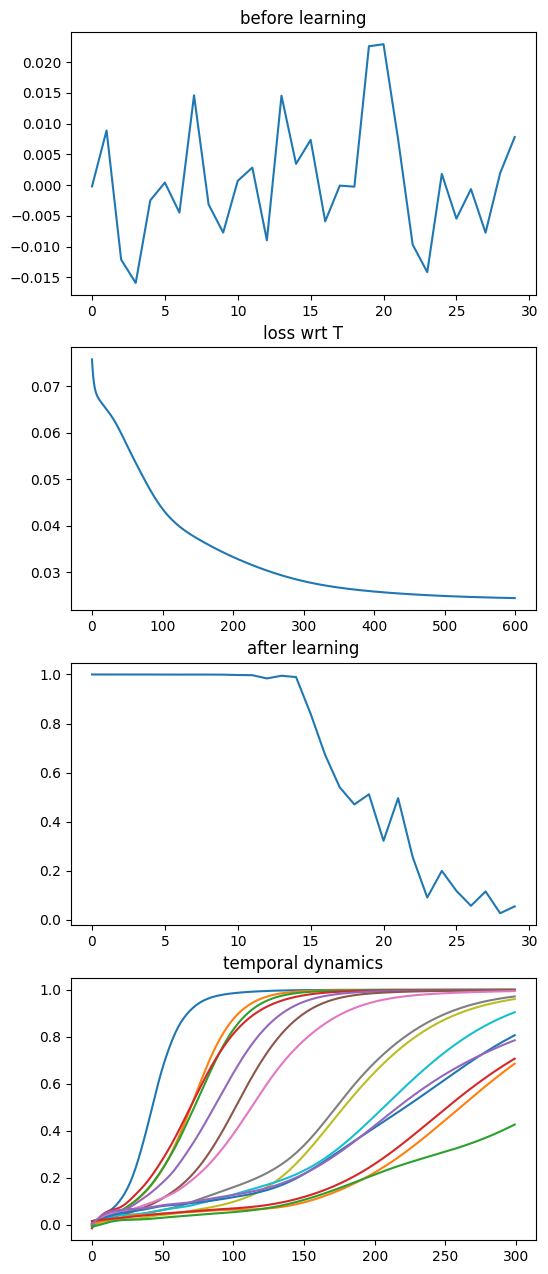

In [271]:
network, loss_val, diag_val = visualize_temporal(shallow_nn, n_iter=600)

## Add another layer

In [94]:
n_comp = 20
input_size = 28 * 28

input_X = torch.from_numpy(X_zero.T.astype(np.float32))

deep_nn = nn.Sequential(
    nn.Linear(input_size, 60, bias=False),
    nn.Linear(60, n_comp, bias=False),
    nn.Linear(n_comp, 60, bias=False),
    nn.Linear(60, input_size, bias=False))

iteration 0 / 500
iteration 50 / 500
iteration 100 / 500
iteration 150 / 500
iteration 200 / 500
iteration 250 / 500
iteration 300 / 500
iteration 350 / 500
iteration 400 / 500
iteration 450 / 500


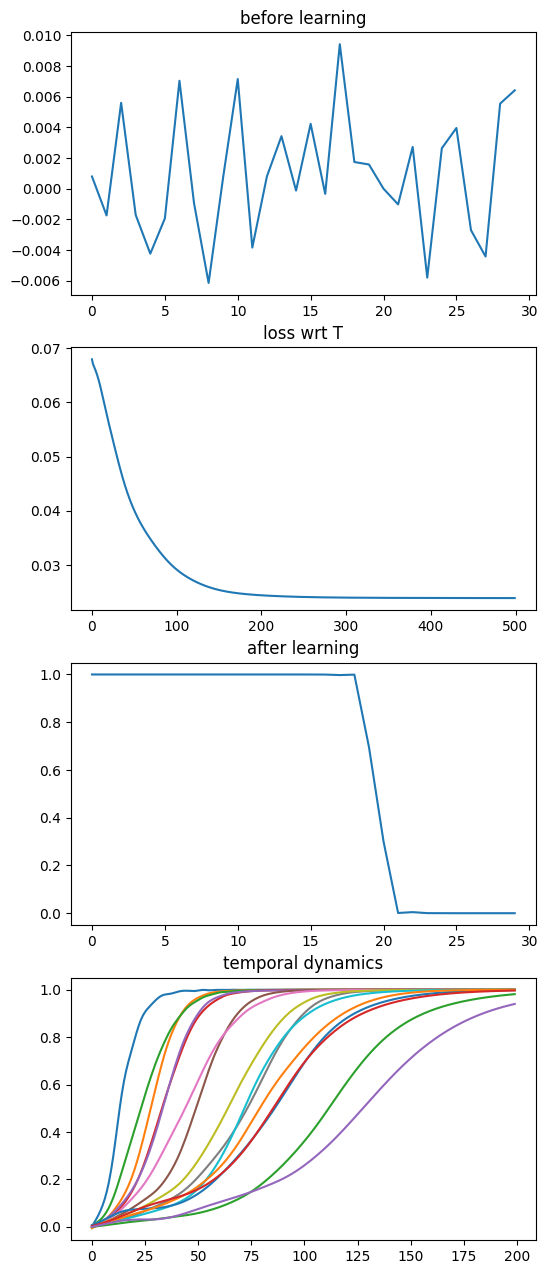

In [95]:
network, loss_val, diag_val = visualize_temporal(deep_nn, n_iter=500, n_item=30, n_plot=15, t_step=200)

## adding weight constaint

In [152]:
def decompose_mtx(weight):
    weight = weight.detach().numpy()
    matrix = weight.T @ weight
    diag = np.diag(components @ matrix @ components.T)
    
    return diag

In [153]:
n_comp = 20
input_size = 28 * 28

input_X = torch.from_numpy(X_zero.T.astype(np.float32))
w_init  = np.random.random(size=[n_comp, input_size])* 0.02 - 0.01
w_init  = torch.tensor(w_init.astype(np.float32), requires_grad=True)

print(input_X.shape)

torch.Size([70000, 784])


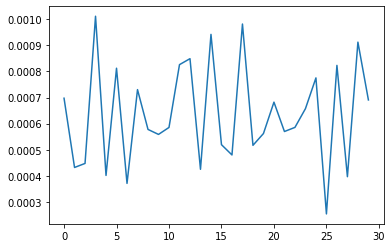

In [154]:
n_item = 30
diag = decompose_mtx(w_init)[0:n_item]
plt.plot(diag)

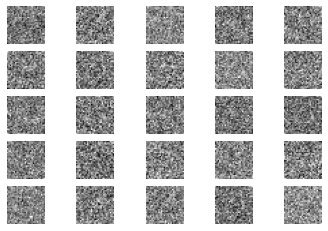

In [155]:
# Before training
with torch.no_grad():
    matrix = w_init.t().mm(w_init)
    output = input_X.mm(matrix)
    output = output.detach().numpy().T
    
    visualize_image(output)

iteration 0 / 1000
iteration 50 / 1000
iteration 100 / 1000
iteration 150 / 1000
iteration 200 / 1000
iteration 250 / 1000
iteration 300 / 1000
iteration 350 / 1000
iteration 400 / 1000
iteration 450 / 1000
iteration 500 / 1000
iteration 550 / 1000
iteration 600 / 1000
iteration 650 / 1000
iteration 700 / 1000
iteration 750 / 1000
iteration 800 / 1000
iteration 850 / 1000
iteration 900 / 1000
iteration 950 / 1000


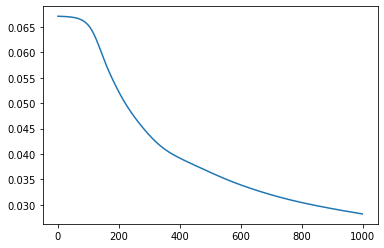

In [84]:
# Gradient descent training
n_iter = 1000
# optimizer = optim.Adam([w_init])
optimizer = optim.SGD([w_init], lr=1.0)

loss_func = nn.MSELoss()
loss_val  = np.zeros(n_iter)
diag_val  = np.zeros([n_iter, n_item])
for iter in range(n_iter):
    if iter % 50 == 0:
        print('iteration %d / %d' % (iter, n_iter))

    # diagonalization of network transformation with PCA basis
    diag = decompose_mtx(w_init)
    diag_val[iter, :] = diag[0:n_item]
    
    optimizer.zero_grad()

    matrix = w_init.t().mm(w_init)
    output_X = input_X.mm(matrix)
    
    loss = loss_func(output_X, input_X)
    loss_val[iter] = loss

    loss.backward()
    optimizer.step()    

plt.plot(range(n_iter), loss_val)

epoch 0 / 200
epoch 50 / 200
epoch 100 / 200
epoch 150 / 200


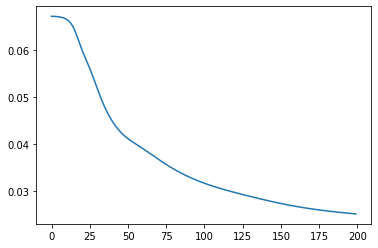

In [156]:
# SGD
n_epoch = 200
batch_size = 100

# optimizer = optim.Adam([w_init])
optimizer = optim.SGD([w_init], lr=0.01)

loss_func = nn.MSELoss()
loss_val  = np.zeros(n_epoch)
diag_val  = np.zeros([n_epoch, n_item])
for epoch in range(n_epoch):
    if epoch % 50 == 0:
        print('epoch %d / %d' % (epoch, n_epoch))

    # diagonalization of network transformation with PCA basis
    diag = decompose_mtx(w_init)
    diag_val[epoch, :] = diag[0:n_item]
    
    shuffle_idx = np.random.permutation(len(input_X))
    batches = torch.split(input_X[shuffle_idx], batch_size)
    
    for batch in batches:
        optimizer.zero_grad()
        
        matrix = w_init.t().mm(w_init)
        output = batch.mm(matrix)
    
        loss = loss_func(batch, output)
        loss.backward()
        
        optimizer.step()
        
    with torch.no_grad():
        matrix = w_init.t().mm(w_init)
        output_X = input_X.mm(matrix)        
        loss_val[epoch] = loss_func(input_X, output_X)

plt.plot(range(n_epoch), loss_val)

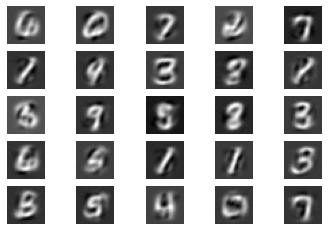

In [157]:
# After training
with torch.no_grad():
    matrix = w_init.t().mm(w_init)
    output = input_X.mm(matrix)
    
    output = output.detach().numpy().T
    output = output + row_mean.reshape([-1, 1])
    
    visualize_image(output)

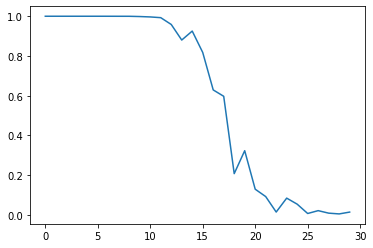

In [158]:
n_item = 30
diag = decompose_mtx(w_init)[0:n_item]
plt.plot(diag)

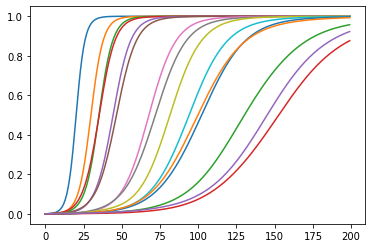

In [159]:
n_plot = 15
t_step = n_epoch
for idx in range(n_plot):
    plt.plot(range(t_step), diag_val[:t_step, idx])

## SGD with deeper network

In [219]:
def decompose_weight(para):
    net_W = ft.reduce(lambda a, b: b @ a, \
                      [w.detach().numpy() for w in para])
    matrix = net_W.T @ net_W
    return np.diag(components @ matrix @ components.T)

In [220]:
def transform(X, para):
    w = ft.reduce(lambda a, b: b.mm(a), para)
    matrix = w.t().mm(w)
    return X.mm(matrix)

In [221]:
n_mid  = 60
n_comp = 20
input_size = 28 * 28

input_X = torch.from_numpy(X_zero.T.astype(np.float32))

w1 = torch.rand([n_mid, input_size])*0.1-0.05
w1 = w1.clone().detach().requires_grad_(True)

w2 = torch.rand([n_comp, n_mid])*0.1-0.05
w2 = w2.clone().detach().requires_grad_(True)

parameters = [w1, w2]

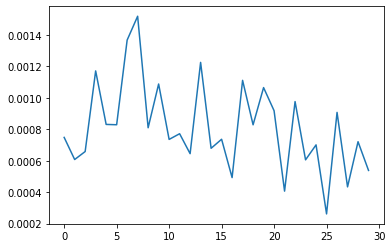

In [222]:
n_item = 30
diag = decompose_weight(parameters)[0:n_item]
plt.plot(diag)

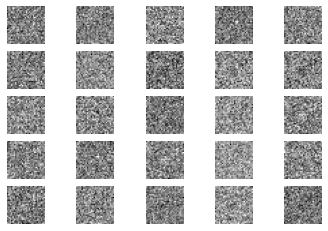

In [223]:
with torch.no_grad():
    output = transform(input_X, parameters)
    output = output.detach().numpy().T
    
    visualize_image(output)

epoch 0 / 500
epoch 100 / 500
epoch 200 / 500
epoch 300 / 500
epoch 400 / 500


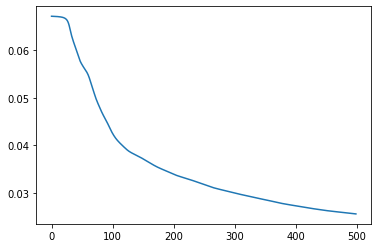

In [224]:
# SGD
n_epoch = 500
batch_size = 100

# optimizer = optim.Adam([w_init])
optimizer = optim.SGD(parameters, lr=0.02)

loss_func = nn.MSELoss()
loss_val  = np.zeros(n_epoch)
diag_val  = np.zeros([n_epoch, n_item])
for epoch in range(n_epoch):
    if epoch % 100 == 0:
        print('epoch %d / %d' % (epoch, n_epoch))

    # diagonalization of network transformation with PCA basis
    diag = decompose_weight(parameters)
    diag_val[epoch, :] = diag[0:n_item]
    
    shuffle_idx = np.random.permutation(len(input_X))
    batches = torch.split(input_X[shuffle_idx], batch_size)
    
    for batch in batches:
        optimizer.zero_grad()
        output = transform(batch, parameters)
    
        loss = loss_func(batch, output)
        loss.backward()        
        optimizer.step()
        
    with torch.no_grad():
        output_X = transform(input_X, parameters)
        loss_val[epoch] = loss_func(input_X, output_X)

plt.plot(range(n_epoch), loss_val)

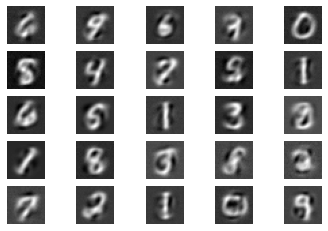

In [225]:
with torch.no_grad():
    output = transform(input_X, parameters)
    output = output.detach().numpy().T + row_mean.reshape([-1, 1])
    
    visualize_image(output)

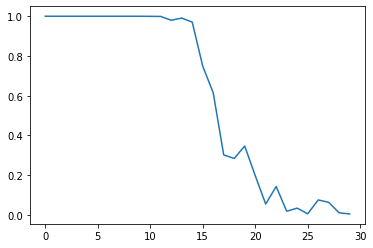

In [226]:
n_item = 30
diag = decompose_weight(parameters)[0:n_item]
plt.plot(diag)

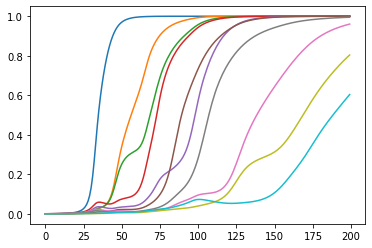

In [227]:
n_plot = 10
t_step = 200
for idx in range(n_plot):
    plt.plot(range(t_step), diag_val[:t_step, idx])

## Deeper Network

In [239]:
w1 = torch.rand([100, input_size])*0.1-0.05
w1 = w1.clone().detach().requires_grad_(True)

w2 = torch.rand([50, 100])*0.1-0.05
w2 = w2.clone().detach().requires_grad_(True)

w3 = torch.rand([n_comp, 50])*0.1-0.05
w3 = w3.clone().detach().requires_grad_(True)

parameters = [w1, w2, w3]

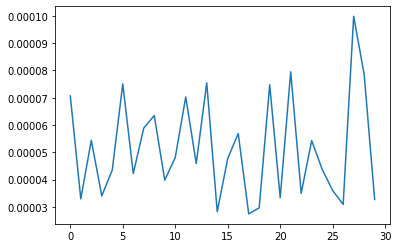

In [240]:
n_item = 30
diag = decompose_weight(parameters)[0:n_item]
plt.plot(diag)

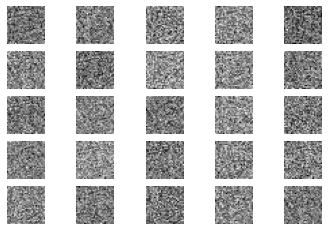

In [241]:
with torch.no_grad():
    output = transform(input_X, parameters)
    output = output.detach().numpy().T
    
    visualize_image(output)

epoch 0 / 2000
epoch 100 / 2000
epoch 200 / 2000
epoch 300 / 2000
epoch 400 / 2000
epoch 500 / 2000
epoch 600 / 2000
epoch 700 / 2000
epoch 800 / 2000
epoch 900 / 2000
epoch 1000 / 2000
epoch 1100 / 2000
epoch 1200 / 2000
epoch 1300 / 2000
epoch 1400 / 2000
epoch 1500 / 2000
epoch 1600 / 2000
epoch 1700 / 2000
epoch 1800 / 2000
epoch 1900 / 2000


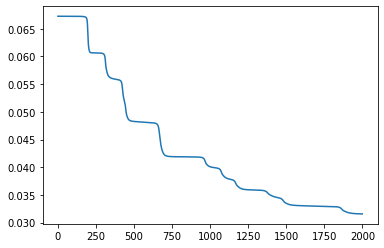

In [242]:
# SGD
n_epoch = 2000
batch_size = 100

# optimizer = optim.Adam([w_init])
optimizer = optim.SGD(parameters, lr=0.02)

loss_func = nn.MSELoss()
loss_val  = np.zeros(n_epoch)
diag_val  = np.zeros([n_epoch, n_item])
for epoch in range(n_epoch):
    if epoch % 100 == 0:
        print('epoch %d / %d' % (epoch, n_epoch))

    # diagonalization of network transformation with PCA basis
    diag = decompose_weight(parameters)
    diag_val[epoch, :] = diag[0:n_item]
    
    shuffle_idx = np.random.permutation(len(input_X))
    batches = torch.split(input_X[shuffle_idx], batch_size)
    
    for batch in batches:
        optimizer.zero_grad()
        output = transform(batch, parameters)
    
        loss = loss_func(batch, output)
        loss.backward()        
        optimizer.step()
        
    with torch.no_grad():
        output_X = transform(input_X, parameters)
        loss_val[epoch] = loss_func(input_X, output_X)

plt.plot(range(n_epoch), loss_val)

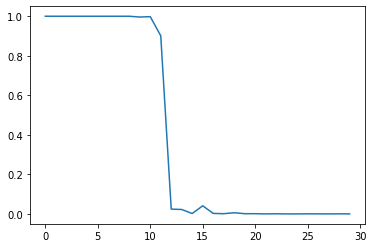

In [243]:
n_item = 30
diag = decompose_weight(parameters)[0:n_item]
plt.plot(diag)

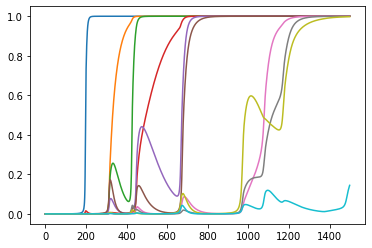

In [247]:
n_plot = 10
t_step = 1500
for idx in range(n_plot):
    plt.plot(range(t_step), diag_val[:t_step, idx])